# Surface Ensemble

**Names:** Matheus Zaia and Samira Oliveira

## Problem


The problem is a grid of $N\times N$ sites, where each site contains either a molecule A, or a molecule B. The binding energy for molecule A is $\varepsilon_A$, while for molecule B is $\varepsilon_B$. The interaction energy between two molecules is given by $\varepsilon_{AA}$, $\varepsilon_{BB}$ and $\varepsilon_{AB}$. Although the grid is finite, we simulate an infinite space by considering periodic conditions of contour (a.k.a. PacMan world). The neighbors of molecule $(i, j)$ are the ones in positions: $(i-1, j)$, $(i+1, j)$, $(i, j-1)$ and $(i, j+1)$, all modulo $N$.

Using the cannonical emsemble theory, we want to find the Helmoltz's free energy according to the concentration of molecules A, and explore the behavior of the system according to the energies $\varepsilon$.

For simplification of units, we use $k_B=1$, and $\varepsilon$'s in the order of some eletron-volts.

## Code

In [1]:
from itertools import product
import numpy as np
import matplotlib.pyplot as plt

The grid will be represented by a matrix, where each element can either be equal to 0 (molecule B) or 1 (molecule B). Using `itertools`, we create an array, `configurations`, of all possible configurations of the system, with $N=4$.

In [2]:
n = 4

row = list(product([0, 1], repeat=n))

configurations = np.array(list(product(row, repeat=n)))

Given that molecule A is represented by the number 1, the sum of all elements in a configuration is the concentration of molecules A in it. We store this information in array `concentrations`.

In [3]:
concentrations = np.sum(np.sum(configurations, axis=1), axis=1)

As various calculations involving this problem require a fixed concentration of molecules in the system, we need to separate the configurations by their concentration. We store this in dictionary `indices`, where the keys are strings with concentration of molecule A, and the values are the indices of the configurations in `configurations` that have that specific concentration.

In [4]:
indices = {}

for j in range(n**2 + 1):
    index = np.where(concentrations == j)[0].tolist()
    indices[f'{j}'] = index

Following, we define the function that will calculate the energy of a configuration $\{k\}$. The energy is given by:
\begin{equation}
E_k = N_A \varepsilon_A + N_B \varepsilon_B + \sum_{(i, j)} \varepsilon_{ij} ,
\end{equation}
where $(i, j)$ represents the energies from interacting neighbors.

In [5]:
def energy(matrix, ea, eb, eaa, ebb, eab, n=4):
  energy = (np.sum(matrix)) * ea + (n**2 - np.sum(matrix)) * eb

  for i in range(n):
    for j in range(n):
      index = [((i + 1)%n, j%n), ((i - 1)%n, j%n), (i%n, (j + 1)%n), (i%n, (j - 1)%n)]
      num_a = 0
      for ind in index:
        num_a += matrix[ind[0], ind[1]]
      if matrix[i, j] == 1:
        energy += (num_a * eaa + (len(index) - num_a) * eab)*0.5
      elif matrix[i, j] == 0:
        energy += (num_a * eab + (len(index) - num_a) * ebb)*0.5
  return energy

Following, we define the functions for the partition function, $Z$ and Helmholtz's free energy, $F$, which are given by:
\begin{equation}
Z = \sum_{\{k\}} e^{-\frac{E_k}{k_B T}},
\end{equation}
and
\begin{equation}
F = -k_B T \ln\left(Z\right).
\end{equation}

In [6]:
def partition_func(T, energies, kb=1):
  return np.sum(np.exp(- energies / (kb * T) ))

def helmholtz(T, energies, kb=1):
  return - kb * T * np.log(partition_func(T=T, energies=energies, kb=kb))

Given this initial data structures, we now analyze how the system will behave according to the choices of $\varepsilon$'s we choose.

## Case 1

Here, we choose values of energies that represent molecules that interact similarly with themselves and the other type of molecule. Given that the adsorption energies are not the decisive factor for changes in ths system, considering a fixed concentration, we will keep $\varepsilon_A$ and $\varepsilon_B$ fixed for all cases, only changing the cross-energy terms. Calculating the energy values for all possible configurations, and storing the energies in `energies`:

In [7]:
ea, eb, eaa, ebb, eab = -0.5, -0.5, -0.5, -0.5, -0.5

energies = np.array([energy(configurations[i], ea, eb, eaa, ebb, eab) for i in range(len(concentrations))])

Ploting the curves of Helmholtz's free energy by temperature, for every possible concentration.

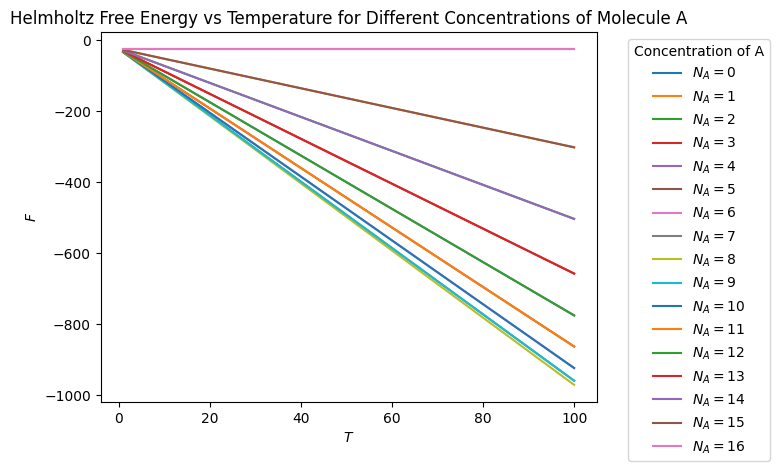

In [8]:
free_energy_helmholtz = {}

T = np.linspace(1, 100, 100)

for i in range(n**2 + 1):
  free_energy = []
  index = indices[f'{i}']
  E = energies[index]

  for t in T:
    free_energy.append(helmholtz(T=t, energies=E))

  free_energy_helmholtz[f'{i}'] = free_energy

for i in range(n**2 + 1):
  plt.plot(T, free_energy_helmholtz[f'{i}'], label=r'$N_A=$' + f'{i}')

plt.xlabel(r'$T$')
plt.ylabel(r'$F$')
plt.title('Helmholtz Free Energy vs Temperature for Different Concentrations of Molecule A')
plt.legend(title="Concentration of A", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

Now, ploting the free energy by concentration of molecule A, for different values of temperature:

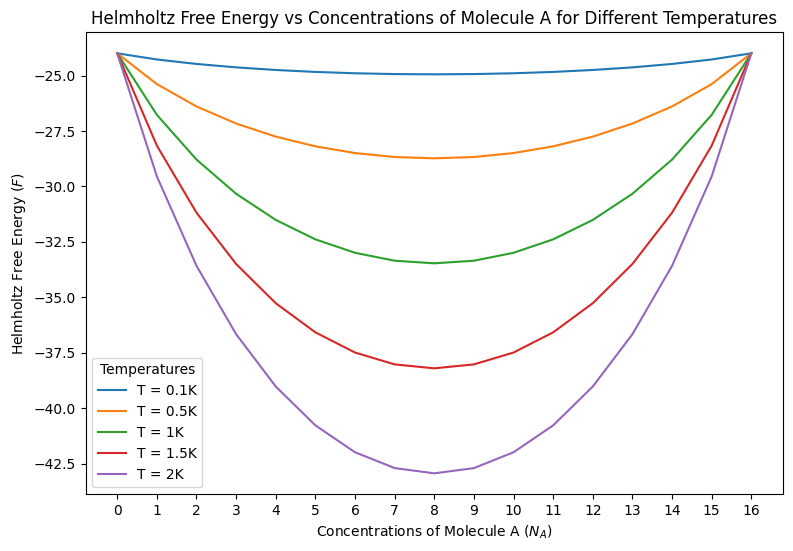

In [9]:
temperatures = [0.1, 0.5, 1, 1.5, 2]

free_energy_helmholtz = {}

for T in temperatures:
    free_energy_helmholtz[T] = {}

    for i in range(n**2 + 1):
        free_energy = []
        index = indices[f'{i}']
        E = energies[index]
        free_energy.append(helmholtz(T=T, energies=E))
        free_energy_helmholtz[T][f'{i}'] = free_energy

plt.figure(figsize=(9, 6))

for T in temperatures:
    concentrations = list(free_energy_helmholtz[T].keys())
    free_energies = [free_energy_helmholtz[T][key][0] for key in concentrations]

    plt.plot(concentrations, free_energies, linestyle='-', label=f'T = {T}K')

plt.xlabel('Concentrations of Molecule A ($N_A$)')
plt.ylabel('Helmholtz Free Energy ($F$)')
plt.title('Helmholtz Free Energy vs Concentrations of Molecule A for Different Temperatures')
plt.legend(title="Temperatures", loc='best')
plt.show()

As we can see, if all $\varepsilon$ values are equal, then the curves of free energy by temperature, for different concentrations have some overlaps. That is, as molecule A is identical to B in terms of interactions, curves that have a concentration $C$ of molecules A will be identical to curves that have a concentration of molecules B equal to $C$. We can observe that, as we can only see 9 out 17 possible curves, given the overlap of 8 of them.

Now, in the free energy by concentration curves, we see that as the temperature increases, the free energy of every concentration decreases, reaching its minimum always at $C_A=8$, where the system has the most amount of configurations possible. Both graphics indicate that this concentration is the more stable one among all concentrations, because the values of freen energy always are reached is these configurations.

It is important to note that this does not implicate that the concentration is changing, as it is fixed for every case, but rather a comparison of stability.

## Case 2

Here, we choose values of energies that represent molecules that have high affinity with the opposite type of molecule. For that, we decrease the value of $\varepsilon_{AB}$:

In [10]:
row = list(product([0, 1], repeat=n))

configurations = np.array(list(product(row, repeat=n)))

concentrations = np.sum(np.sum(configurations, axis=1), axis=1)

indices = {}

for j in range(n**2 + 1):
    index = np.where(concentrations == j)[0].tolist()
    indices[f'{j}'] = index

ea, eb, eaa, ebb, eab = -0.5, -0.5, -0.8, -0.3, -1.5

energies = np.array([energy(configurations[i], ea, eb, eaa, ebb, eab) for i in range(len(concentrations))])

Ploting the curves of Helmholtz's free energy by temperature, for every possible concentration.

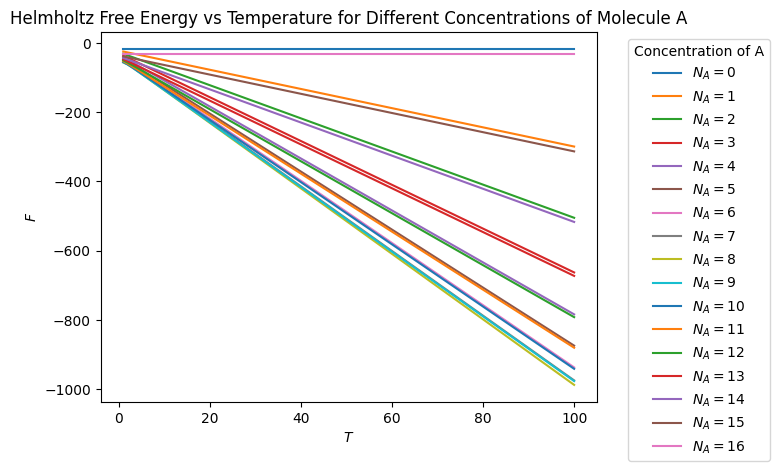

In [11]:
free_energy_helmholtz = {}

T = np.linspace(1, 100, 100)

for i in range(n**2 + 1):
  free_energy = []
  index = indices[f'{i}']
  E = energies[index]

  for t in T:
    free_energy.append(helmholtz(T=t, energies=E))

  free_energy_helmholtz[f'{i}'] = free_energy

for i in range(n**2 + 1):
  plt.plot(T, free_energy_helmholtz[f'{i}'], label=r'$N_A=$' + f'{i}')

plt.xlabel(r'$T$')
plt.ylabel(r'$F$')
plt.title('Helmholtz Free Energy vs Temperature for Different Concentrations of Molecule A')
plt.legend(title="Concentration of A", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

Now, ploting the free energy by concentration of molecule A, for different values of temperature:

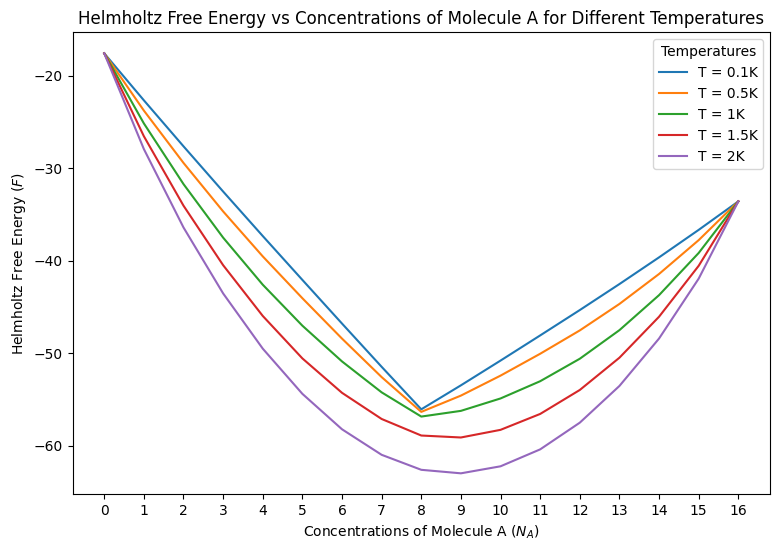

In [12]:
temperatures = [0.1, 0.5, 1, 1.5, 2]

free_energy_helmholtz = {}

for T in temperatures:
    free_energy_helmholtz[T] = {}

    for i in range(n**2 + 1):
        free_energy = []
        index = indices[f'{i}']
        E = energies[index]
        free_energy.append(helmholtz(T=T, energies=E))
        free_energy_helmholtz[T][f'{i}'] = free_energy

plt.figure(figsize=(9, 6))

for T in temperatures:
    concentrations = list(free_energy_helmholtz[T].keys())
    free_energies = [free_energy_helmholtz[T][key][0] for key in concentrations]

    plt.plot(concentrations, free_energies, linestyle='-', label=f'T = {T}K')

plt.xlabel('Concentrations of Molecule A ($N_A$)')
plt.ylabel('Helmholtz Free Energy ($F$)')
plt.title('Helmholtz Free Energy vs Concentrations of Molecule A for Different Temperatures')
plt.legend(title="Temperatures", loc='best')
plt.show()

Finding the configuration with the least energy with concentration equal to $C_A=8$.

In [13]:
concentration_8_indices = indices['8']
concentration_8_energies = energies[concentration_8_indices]

min_energy_index_in_concentration_8 = np.argmin(concentration_8_energies)
global_min_index = concentration_8_indices[min_energy_index_in_concentration_8]

min_energy_configuration = configurations[global_min_index]
min_energy = energies[global_min_index]

print("Configuration with minimal energy (concentration = 8):")
print(min_energy_configuration)

Configuration with minimal energy (concentration = 8):
[[0 1 0 1]
 [1 0 1 0]
 [0 1 0 1]
 [1 0 1 0]]


As we can see, when molecules have a greater affinity with the opposite species than themselves, the tendency is the system to organize itself to surround every molecule A with molecules B around it, and vice-versa, as we can see above. The other graphics show the same behavior as Case 1.

## Case 3

Here, we choose values of energies that represent molecules that have high repulsion with the opposite type of molecule, interacting better with themselves. For that, we increase the value of $\varepsilon_{AB}$:

In [14]:
row = list(product([0, 1], repeat=n))

configurations = np.array(list(product(row, repeat=n)))

concentrations = np.sum(np.sum(configurations, axis=1), axis=1)

indices = {}

for j in range(n**2 + 1):
    index = np.where(concentrations == j)[0].tolist()
    indices[f'{j}'] = index

ea, eb, eaa, ebb, eab = -0.5, -0.5, -0.8, -0.3, 10.5

energies = np.array([energy(configurations[i], ea, eb, eaa, ebb, eab) for i in range(len(concentrations))])

Ploting the curves of Helmholtz's free energy by temperature, for every possible concentration.

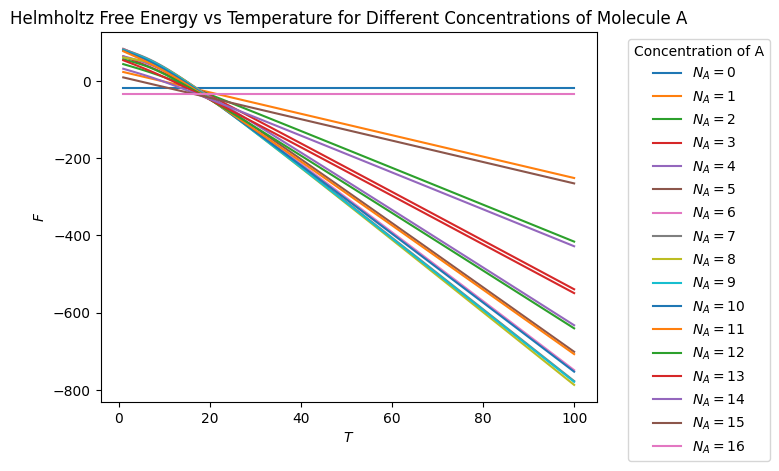

In [15]:
free_energy_helmholtz = {}

T = np.linspace(1, 100, 100)

for i in range(n**2 + 1):
  free_energy = []
  index = indices[f'{i}']
  E = energies[index]

  for t in T:
    free_energy.append(helmholtz(T=t, energies=E))

  free_energy_helmholtz[f'{i}'] = free_energy

for i in range(n**2 + 1):
  plt.plot(T, free_energy_helmholtz[f'{i}'], label=r'$N_A=$' + f'{i}')

plt.xlabel(r'$T$')
plt.ylabel(r'$F$')
plt.title('Helmholtz Free Energy vs Temperature for Different Concentrations of Molecule A')
plt.legend(title="Concentration of A", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

Now, ploting the free energy by concentration of molecule A, for different values of temperature:

<ipython-input-6-391165acc35e>:5: RuntimeWarning: divide by zero encountered in log
  return - kb * T * np.log(partition_func(T=T, energies=energies, kb=kb))


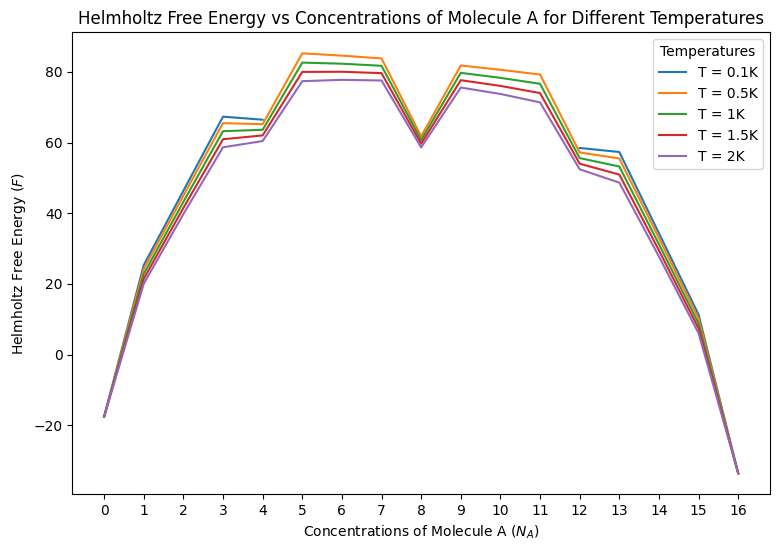

In [16]:
temperatures = [0.1, 0.5, 1, 1.5, 2]

free_energy_helmholtz = {}

for T in temperatures:
    free_energy_helmholtz[T] = {}

    for i in range(n**2 + 1):
        free_energy = []
        index = indices[f'{i}']
        E = energies[index]
        free_energy.append(helmholtz(T=T, energies=E))
        free_energy_helmholtz[T][f'{i}'] = free_energy

plt.figure(figsize=(9, 6))

for T in temperatures:
    concentrations = list(free_energy_helmholtz[T].keys())
    free_energies = [free_energy_helmholtz[T][key][0] for key in concentrations]

    plt.plot(concentrations, free_energies, linestyle='-', label=f'T = {T}K')

plt.xlabel('Concentrations of Molecule A ($N_A$)')
plt.ylabel('Helmholtz Free Energy ($F$)')
plt.title('Helmholtz Free Energy vs Concentrations of Molecule A for Different Temperatures')
plt.legend(title="Temperatures", loc='best')
plt.show()

Finding the configuration with the least energy with concentration equal to $C_A=8$.

In [17]:
concentration_8_indices = indices['8']
concentration_8_energies = energies[concentration_8_indices]

min_energy_index_in_concentration_8 = np.argmin(concentration_8_energies)
global_min_index = concentration_8_indices[min_energy_index_in_concentration_8]

min_energy_configuration = configurations[global_min_index]
min_energy = energies[global_min_index]

print("Configuration with minimal energy (concentration = 8):")
print(min_energy_configuration)

Configuration with minimal energy (concentration = 8):
[[0 0 0 0]
 [0 0 0 0]
 [1 1 1 1]
 [1 1 1 1]]


As we can see, when molecules have a greater affinity with themselves, the miminum of energy is obtained by phase separation. As we can see above, when the concentration is equal to 8, the minimum of Helmholtz's free energy is obtained with a configuration where the molecules are distributed in separate clusters. When the interaction $\varepsilon_{AB}>>0$, the system shows signs of instability in lower temperatures. In our case, for $T=10$K, the concentration $C_A=8$ actually was not a point of stability, but rather a point of maximum of energy, meaning the system would run away from this configuration, if possible (in our case, as concentration is fixed, it is not possible).